# Introduction to Deep Learning with Tensorflow and Keras

In [120]:
from functools import partial
import pandas as pd
from scipy.stats import reciprocal
import sklearn
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import *

## Load Data

In [2]:
def load_data(dataset):
    if dataset == "fashion_mnist":
        fashion_mnist = keras.datasets.fashion_mnist
        (X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
        X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
        y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
        X_test = X_test / 255.
    elif dataset == "housing":
        housing = fetch_california_housing()
        X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(X_test)
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

In [3]:
def plot_fitting(history):
    pd.DataFrame(history.history).plot(figsize=(8, 6))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

## Sequential API

In [21]:
model = Sequential()
model.add(Flatten(input_shape=[28, 28]))
model.add(Dense(300, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))

In [22]:
# alternative way
# keras.backend.clear_session()
# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28, 28]),
#     keras.layers.Dense(300, activation="relu"),
#     keras.layers.Dense(100, activation="relu"),
#     keras.layers.Dense(10, activation="softmax")
#])

In [23]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [24]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = load_data("fashion_mnist")

In [25]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), verbose=0)

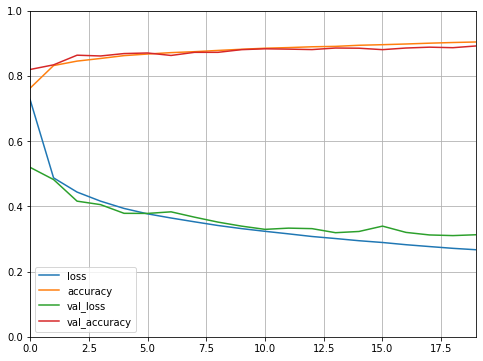

In [26]:
plot_fitting(history)

In [27]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 27us/sample - loss: 0.3456 - accuracy: 0.8782


[0.34556306056976316, 0.8782]

In [28]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = load_data("housing")

In [33]:
model = Sequential([
    Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=SGD(lr=1e-3))

In [34]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), verbose=0)

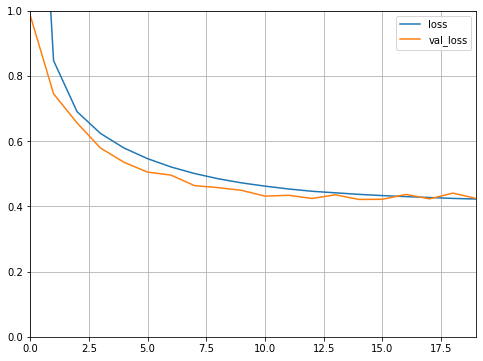

In [35]:
plot_fitting(history)

In [36]:
model.evaluate(X_test, y_test)

5160/5160 [==============================] - 0s 17us/sample - loss: 0.4180


0.4179689273353695

## Functional API

In [37]:
input = Input(shape=X_train.shape[1:])
hidden1 = Dense(30, activation="relu")(input)
hidden2 = Dense(30, activation="relu")(hidden1)
concat = concatenate([input, hidden2])
output = Dense(1)(concat)
model = Model(inputs=[input], outputs=[output])

In [38]:
model.compile(loss="mean_squared_error", optimizer=SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), verbose=0)

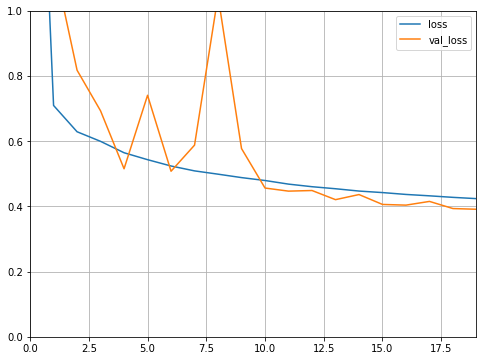

5160/5160 [==============================] - 0s 17us/sample - loss: 0.4159


0.4158699086470197

In [39]:
plot_fitting(history)
model.evaluate(X_test, y_test)

## Subclassing API

In [40]:
class WideAndDeepModel(Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = Dense(units, activation=activation)
        self.hidden2 = Dense(units, activation=activation)
        self.main_output = Dense(1)
        self.aux_output = Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

In [41]:
model = WideAndDeepModel(30, activation="relu")

In [42]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=SGD(lr=1e-3))

In [43]:
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

In [44]:
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=20, validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)), verbose=0)

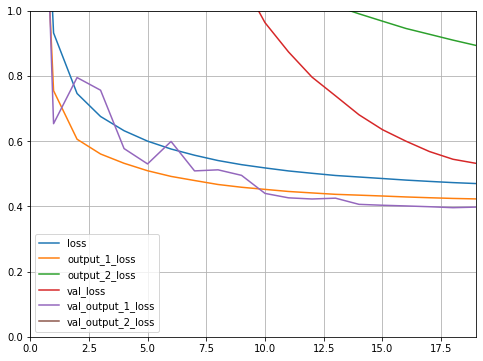

5160/5160 [==============================] - 0s 19us/sample - loss: 0.4602 - output_1_loss: 0.4145 - output_2_loss: 0.8736


[0.4602110924646836, 0.41454142, 0.87363124]

In [45]:
plot_fitting(history)
model.evaluate((X_test_A, X_test_B), (y_test, y_test))

## Save and Load Model

In [48]:
# for functional or sequential model only; does not work for subclassed models
# model.save("my_keras_model.h5") 
# model = keras.models.load_model("my_keras_model.h5")

## Using Callbacks during Training

In [49]:
keras.backend.clear_session()

In [54]:
model = Sequential([
    Dense(30, activation="relu", input_shape=[8]),
    Dense(30, activation="relu"),
    Dense(1)
])    
model.compile(loss="mse", optimizer=SGD(lr=5e-3))

In [55]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 48us/sample - loss: 1.0526 - val_loss: 0.5712
Epoch 2/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4910 - val_loss: 0.4177
Epoch 3/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.4269 - val_loss: 0.5008
Epoch 4/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4037 - val_loss: 0.3739
Epoch 5/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.3888 - val_loss: 0.4251
Epoch 6/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.3817 - val_loss: 0.3709
Epoch 7/10
11610/11610 [==============================] - 0s 29us/sample - loss: 0.3761 - val_loss: 0.5303
Epoch 8/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.3726 - val_loss: 0.4634
Epoch 9/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.3688 - val_l

In [57]:
model.evaluate(X_test, y_test)

5160/5160 [==============================] - 0s 18us/sample - loss: 0.3596


0.3596030403477277

In [58]:
model.compile(loss="mse", optimizer=SGD(lr=5e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, early_stopping_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 56us/sample - loss: 0.3603 - val_loss: 0.4776
Epoch 2/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.3593 - val_loss: 0.3384
Epoch 3/100
11610/11610 [==============================] - 0s 35us/sample - loss: 0.3558 - val_loss: 0.4490
Epoch 4/100
11610/11610 [==============================] - 0s 38us/sample - loss: 0.3541 - val_loss: 0.5125
Epoch 5/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.3522 - val_loss: 0.8237
Epoch 6/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.3521 - val_loss: 0.3297
Epoch 7/100
11610/11610 [==============================] - 0s 38us/sample - loss: 0.3458 - val_loss: 0.5240
Epoch 8/100
11610/11610 [==============================] - 0s 37us/sample - loss: 0.3459 - val_loss: 0.3310
Epoch 9/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.342

In [59]:
model.evaluate(X_test, y_test)

5160/5160 [==============================] - 0s 21us/sample - loss: 0.3352


0.335230224931887

In [61]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [62]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid), callbacks=[val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/5
11040/11610 [===========================>..] - ETA: 0s - loss: 0.3269
val/train: 0.99
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3275 - val_loss: 0.3229
Epoch 2/5
11168/11610 [===========================>..] - ETA: 0s - loss: 0.3284
val/train: 0.96
11610/11610 [==============================] - 0s 34us/sample - loss: 0.3267 - val_loss: 0.3135
Epoch 3/5
10944/11610 [===========================>..] - ETA: 0s - loss: 0.3254
val/train: 1.00
11610/11610 [==============================] - 0s 35us/sample - loss: 0.3243 - val_loss: 0.3241
Epoch 4/5
11040/11610 [===========================>..] - ETA: 0s - loss: 0.3243
val/train: 1.05
11610/11610 [==============================] - 0s 35us/sample - loss: 0.3237 - val_loss: 0.3409
Epoch 5/5
10304/11610 [=========================>....] - ETA: 0s - loss: 0.3180
val/train: 1.00
11610/11610 [==============================] - 0s 36us/sample - loss: 0.3207 - val_loss

## Hyperparameter Tuning

In [63]:
keras.backend.clear_session()

In [66]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=5e-3, input_shape=[8]):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation="relu"))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer=SGD(lr=learning_rate))
    return model

In [67]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [68]:
keras_reg.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=10)], verbose=0)

In [74]:
param_grid = {
    "n_hidden": [0, 1, 2],
    "n_neurons": np.arange(10, 51, 10),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_grid, n_iter=10, cv=2, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=5)], verbose=0)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] learning_rate=0.0023707483137978295, n_hidden=2, n_neurons=20 ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


5805/5805 [==============================] - 0s 16us/sample - loss: 0.4675
[CV]  learning_rate=0.0023707483137978295, n_hidden=2, n_neurons=20, total=   2.3s
[CV] learning_rate=0.0023707483137978295, n_hidden=2, n_neurons=20 ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


5805/5805 [==============================] - 0s 16us/sample - loss: 0.4547
[CV]  learning_rate=0.0023707483137978295, n_hidden=2, n_neurons=20, total=   2.3s
[CV] learning_rate=0.005023925170206776, n_hidden=0, n_neurons=20 ....
5805/5805 [==============================] - 0s 15us/sample - loss: 1.5013
[CV]  learning_rate=0.005023925170206776, n_hidden=0, n_neurons=20, total=   2.1s
[CV] learning_rate=0.005023925170206776, n_hidden=0, n_neurons=20 ....
5805/5805 [==============================] - 0s 14us/sample - loss: 0.5631
[CV]  learning_rate=0.005023925170206776, n_hidden=0, n_neurons=20, total=   1.4s
[CV] learning_rate=0.004833092527028704, n_hidden=0, n_neurons=30 ....
5805/5805 [==============================] - 0s 14us/sample - loss: 1.4066
[CV]  learning_rate=0.004833092527028704, n_hidden=0, n_neurons=30, total=   1.4s
[CV] learning_rate=0.004833092527028704, n_hidden=0, n_neurons=30 ....
5805/5805 [==============================] - 0s 14us/sample - loss: 0.5525
[CV]  learni

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   39.0s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x16783be90>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14adfa210>,
                                        'n_hidden': [0, 1, 2],
                                        'n_neurons': array([10, 20, 30, 40, 50])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [75]:
rnd_search_cv.best_params_

{'learning_rate': 0.012450623010385964, 'n_hidden': 2, 'n_neurons': 40}

In [76]:
rnd_search_cv.best_score_

-0.37097056789658994

In [77]:
rnd_search_cv.score(X_test, y_test)

5160/5160 [==============================] - 0s 16us/sample - loss: 0.3607


-0.36071201438127565

In [78]:
model = rnd_search_cv.best_estimator_.model
model

In [79]:
model.evaluate(X_test, y_test)

5160/5160 [==============================] - 0s 17us/sample - loss: 0.3607


0.36071201438127565

## Initialization

In [80]:
Dense(10, activation="relu", kernel_initializer="he_normal")

In [81]:
init = keras.initializers.VarianceScaling(scale=2., mode="fan_avg", distribution="uniform")
Dense(10, activation="relu", kernel_initializer=init)

## Activation Functions

In [82]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [83]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = load_data("fashion_mnist")

In [89]:
model = keras.models.Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(300, kernel_initializer="he_normal"),
    LeakyReLU(),
    Dense(100, kernel_initializer="he_normal"),
    LeakyReLU(),
    Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=SGD(lr=1e-3), metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=0)
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 27us/sample - loss: 0.5205 - accuracy: 0.8189


[0.520495384836197, 0.8189]

In [90]:
model = keras.models.Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(300, kernel_initializer="he_normal"),
    PReLU(),
    Dense(100, kernel_initializer="he_normal"),
    PReLU(),
    Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=SGD(lr=1e-3), metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=0)
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 28us/sample - loss: 0.5158 - accuracy: 0.8221


[0.5157931370258332, 0.8221]

## Batch Normalization

In [92]:
model = keras.models.Sequential([
    Flatten(input_shape=[28, 28]),
    BatchNormalization(),
    Dense(300, activation="relu"),
    BatchNormalization(),
    Dense(100, activation="relu"),
    BatchNormalization(),
    Dense(10, activation="softmax")
])

In [93]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [94]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=SGD(lr=1e-3), metrics=["accuracy"])

In [95]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=0)

In [96]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 30us/sample - loss: 0.3994 - accuracy: 0.8575


[0.39943455929756166, 0.8575]

## Gradient Clipping

In [98]:
model = keras.models.Sequential([
    Flatten(input_shape=[28, 28]),
    BatchNormalization(),
    Dense(300, activation="relu"),
    BatchNormalization(),
    Dense(100, activation="relu"),
    BatchNormalization(),
    Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=SGD(lr=1e-3, clipvalue=1.0), metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=0)
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 30us/sample - loss: 0.3974 - accuracy: 0.8616


[0.3974479436397553, 0.8616]

## Optimizers

In [100]:
SGD(lr=0.001, momentum=0.9)

In [101]:
SGD(lr=0.001, momentum=0.9, nesterov=True)

In [102]:
Adagrad(lr=0.001)

In [103]:
RMSprop(lr=0.001, rho=0.9)

In [104]:
Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [105]:
Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

In [106]:
Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Learning Rate Scheduling

In [110]:
# power scheduling
optimizer = SGD(lr=0.01, decay=1e-4)
model = keras.models.Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=0)
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 27us/sample - loss: 0.4066 - accuracy: 0.8528


[0.40657550611495974, 0.8528]

In [112]:
# exponential scheduling
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

model = keras.models.Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=0, callbacks=[lr_scheduler])
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 28us/sample - loss: 0.3629 - accuracy: 0.8793


[0.3629412694454193, 0.8793]

In [113]:
# performance scheduling
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    Dense(10, activation="softmax")
])
optimizer = SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=0, callbacks=[lr_scheduler])
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 28us/sample - loss: 0.4907 - accuracy: 0.8409


[0.49070993309020994, 0.8409]

In [114]:
# tf.keras schedulers
model = keras.models.Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=0)
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 28us/sample - loss: 0.4038 - accuracy: 0.8525


[0.4038208547830582, 0.8525]

## $\ell_1$ and $\ell_2$ Regularization

In [118]:
RegularizedDense = partial(Dense, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.01))

model = Sequential([
    Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=0)
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 31us/sample - loss: 0.9143 - accuracy: 0.7871


[0.9142527238845826, 0.7871]

## Dropout

In [127]:
model = Sequential([
    Flatten(input_shape=[28, 28]),
    Dropout(rate=0.2),
    Dense(300, activation="elu", kernel_initializer="he_normal"),
    Dropout(rate=0.2),
    Dense(100, activation="elu", kernel_initializer="he_normal"),
    Dropout(rate=0.2),
    Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=0)
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 30us/sample - loss: 0.3432 - accuracy: 0.8715


[0.34316494522094726, 0.8715]

In [129]:
y_probas = np.stack([model(X_test, training=True) for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_pred = np.argmax(y_proba, axis=1)
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



0.8735

## Max Norm

In [125]:
MaxNormDense = partial(Dense, activation="selu", kernel_initializer="lecun_normal", kernel_constraint=keras.constraints.max_norm(1.))

In [126]:
model = Sequential([
    Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=0)
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 35us/sample - loss: 0.4059 - accuracy: 0.8512


[0.40591214513778684, 0.8512]